# A simple tetrode pipeline

Here, we make a simple sorting pipeline for tetrode data, based on data collected by Bri Vandrey in the Nolan Lab (University of Edinburgh). First load in the packages we need and the recording

In [15]:
from pathlib import Path

import spikeinterface.full as si
import probeinterface as pi



In [16]:
si.set_global_job_kwargs(n_jobs=0.8)

In [ ]:
# base_data_folder = Path("/home/samuel/DataSpikeSorting/data_cns_lyon_2025/")
# working_folder = Path("/home/samuel/DataSpikeSorting/data_cns_lyon_2025/results")

base_data_folder = Path("/mnt/data/sam/DataSpikeSorting/school_neuralnet_2025/raw_datas/")
working_folder = Path("/mnt/data/sam/DataSpikeSorting/school_neuralnet_2025/results")


# base_data_folder = Path("/home/pierre/data/gdr/bordeaux/raw_datas/")
# working_folder = Path("/home/pierre/data/gdr/bordeaux/results")

recording_name = "1544_2023-04-21_09-55-34_of"
path_to_recording = base_data_folder / recording_name

results_folder = working_folder / recording_name

recording = si.read_openephys(path_to_recording, stream_id="CH")
recording

The data comes from four tetrodes. Luckily, `ProbeInterface` has a `generate_tetrode` function. We can use that to make four tetrodes, spaced out a little. We'll combine them all into a `ProbeGroup`

In [4]:
tetrode_group = pi.ProbeGroup()
for a in range(4):
    one_tetrode = pi.generate_tetrode()
    one_tetrode.move([a*250,0])
    tetrode_group.add_probe(one_tetrode)

# Wire it up
tetrode_group.set_global_device_channel_indices(range(16))

# And set the probe
recording = recording.set_probegroup(tetrode_group)

To make sure we've done the probe properly, let's plot it

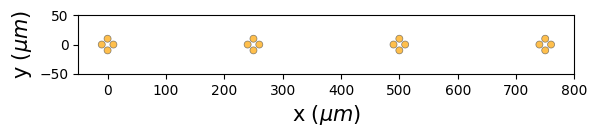

In [5]:
si.plot_probe_map(recording)

Each tetrode is quite far apart, and should (usually) be treated independently. Hence we'll split the recording into groups. Since we attached the Probe as a `ProbeGroup`, it already knows about the groups.

In [7]:
grouped_recording = recording.split_by('group')
grouped_recording

{0: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                        2,219.79s (37.00 minutes) - int16 dtype - 508.07 MiB,
 1: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                        2,219.79s (37.00 minutes) - int16 dtype - 508.07 MiB,
 2: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                        2,219.79s (37.00 minutes) - int16 dtype - 508.07 MiB,
 3: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                        2,219.79s (37.00 minutes) - int16 dtype - 508.07 MiB}


We'll now apply some light preprocessing (note: tetrodes don't do well with common referencing. Read more:  https://spikeinterface.readthedocs.io/en/stable/tutorials/forhowto/plot_1_working_with_tetrodes.html) and check if there are any bad channels

In [8]:
preprocessed_recording = si.bandpass_filter(grouped_recording)

recording_good_channels = si.detect_and_remove_bad_channels(preprocessed_recording,)

print(recording_good_channels)

/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/src/spikeinterface/preprocessing/detect_bad_channels.py:298: UserWarning: Over 1/3 of channels are detected as bad. In the presence of a highnumber of dead / noisy channels, bad channel detection may fail (good channels may be erroneously labeled as dead).
  warnings.warn(


{0: DetectAndRemoveBadChannelsRecording: 4 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                                     2,219.79s (37.00 minutes) - int16 dtype - 508.07 MiB, 1: DetectAndRemoveBadChannelsRecording: 2 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                                     2,219.79s (37.00 minutes) - int16 dtype - 254.04 MiB, 2: DetectAndRemoveBadChannelsRecording: 3 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                                     2,219.79s (37.00 minutes) - int16 dtype - 381.05 MiB, 3: DetectAndRemoveBadChannelsRecording: 4 channels - 30.0kHz - 1 segments - 66,593,792 samples 
                                     2,219.79s (37.00 minutes) - int16 dtype - 508.07 MiB}


Nice. Group 2 only has 3 channels, so a bad channel from that group has been removed.

Motion detection algorithms are for high density probes (not tetrodes). Luckily, tetrodes are usually pretty stable. So we can move on to sorting. The most commonly used algorithm for tetrodes is MountainSort. Let's try the latest version of that. Reading the GitHub page (https://github.com/flatironinstitute/mountainsort5) it sounds like if we don't have drift we should use sorting scheme 2.

In [ ]:
sorting = si.run_sorter(
    sorter_name="mountainsort5", recording=recording_good_channels, scheme='2'
    folder=results_folder / "sorter_MS5",
    )


write_binary_recording 
engine=process - n_jobs=1 - samples_per_chunk=30,000 - chunk_memory=468.75 KiB - total_memory=468.75 KiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.074 seconds ***
Running phase 1 sorting
Number of channels: 4
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [10.  0.]
Channel 1: [6.123234e-16 1.000000e+01]
Channel 2: [-1.0000000e+01  1.2246468e-15]
Channel 3: [-1.8369702e-15 -1.0000000e+01]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 200
[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]

m = 0 (nbhd size: 4)
m = 1 (nbhd size: 4)
m = 2 (nbhd size: 4)
m = 3 (nbhd size: 4)
Detected 7369 spikes
*** MS5 Elapsed time for detect_spikes: 0.263 seconds ***
Removing duplicate times
*** MS5 Elapsed time for remove_duplicate_tim

Since the input recording was a dictionary of the four grouped recording, the sorting output is also a dict of four grouped sortings:

In [11]:
sorting

{0: NpzSortingExtractor: 8 units - 1 segments - 30.0kHz
   file_path: /home/samuel.garcia/Documents/SpikeInterface/school_spike_sorting_neuralnet_bordeaux_2025/bonus/mountainsort5_output/0/sorter_output/firings.npz,
 1: NpzSortingExtractor: 2 units - 1 segments - 30.0kHz
   file_path: /home/samuel.garcia/Documents/SpikeInterface/school_spike_sorting_neuralnet_bordeaux_2025/bonus/mountainsort5_output/1/sorter_output/firings.npz,
 2: NpzSortingExtractor: 4 units - 1 segments - 30.0kHz
   file_path: /home/samuel.garcia/Documents/SpikeInterface/school_spike_sorting_neuralnet_bordeaux_2025/bonus/mountainsort5_output/2/sorter_output/firings.npz,
 3: NpzSortingExtractor: 6 units - 1 segments - 30.0kHz
   file_path: /home/samuel.garcia/Documents/SpikeInterface/school_spike_sorting_neuralnet_bordeaux_2025/bonus/mountainsort5_output/3/sorter_output/firings.npz}

Let's now make a sorting analyzer and compute some extensions. PCA metrics are particularly useful for tetrode data. Since the recording is quite small, I'll make an analyzer in memory and then save it later.

In [14]:
# Note: make sure you use the preprocessed recording here!
analyzer = si.create_sorting_analyzer(sorting, recording_good_channels,
                                      format="memory")


analyzer.compute({
    "templates": {},
    "waveforms": {},
    "random_spikes": {},
    "correlograms": {},
    "noise_levels": {'method': 'std'},
    "spike_amplitudes": {},
    "spike_locations": {},
    "template_metrics": {},
    "unit_locations": {},
    "template_similarity": {'method': 'l1'},
    "quality_metrics": {},
    "principal_components": {}
})

estimate_sparsity (no parallelization):   0%|          | 0/2220 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/2220 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/20 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (no parallelization):   0%|          | 0/2220 [00:00<?, ?it/s]

/home/samuel.garcia/.virtualenvs/py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/samuel.garcia/.virtualenvs/py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/samuel.garcia/.virtualenvs/py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


calculate pc_metrics:   0%|          | 0/20 [00:00<?, ?it/s]

Now that the computations are done, I'll save the analyzer

In [ ]:
analyzer.save_as(format="binary_folder", folder=results_folder/"analyzer_MS5")

Finally, let's export a report to see what our units look like

In [ ]:
si.export_report(analyzer, output_folder = results_folder / "tetrode_report_MS5")

Go take a look at the report to see your units. Or use some of the `SpikeInterface` widgets to take a look within the notebook